In [3]:
import mujoco_py
from types import MethodType
import glfw
import gym

In [4]:
import numpy as np
from gym.envs.mujoco import mujoco_env
from gym import utils

def mass_center(model, sim):
    mass = np.expand_dims(model.body_mass, 1)
    xpos = sim.data.xipos
    return (np.sum(mass * xpos, 0) / np.sum(mass))[0]

class HumanoidEnv(mujoco_env.MujocoEnv, utils.EzPickle):
    def __init__(self):
        self.time_alive = 0
        mujoco_env.MujocoEnv.__init__(self, 'humanoid.xml', 5)
        utils.EzPickle.__init__(self)

    def _get_obs(self):
        data = self.sim.data
        return np.concatenate([data.qpos.flat[2:],
                               data.qvel.flat,
                               data.cinert.flat,
                               data.cvel.flat,
                               data.qfrc_actuator.flat,
                               data.cfrc_ext.flat])

    def step(self, a):
        pos_before = mass_center(self.model, self.sim)
        self.do_simulation(a, self.frame_skip)
        pos_after = mass_center(self.model, self.sim)
        alive_bonus = 5.0
        data = self.sim.data
        lin_vel_cost = 3 * (pos_after - pos_before) / self.dt
#         lin_vel_cost = 1.25 * (pos_after - pos_before) / self.dt
        quad_ctrl_cost = 0.1 * np.square(data.ctrl).sum()
        quad_impact_cost = .5e-6 * np.square(data.cfrc_ext).sum()
        quad_impact_cost = min(quad_impact_cost, 10)
            
        self.time_alive += self.dt
        time_alive_bonus = self.time_alive*10
            
        reward = lin_vel_cost - quad_ctrl_cost - quad_impact_cost + time_alive_bonus
        qpos = self.sim.data.qpos
        done = bool((qpos[2] < 1.0) | (qpos[2] > 2.0))
        return self._get_obs(), reward, done, dict(reward_linvel=lin_vel_cost, reward_quadctrl=-quad_ctrl_cost, reward_alive=alive_bonus, reward_impact=-quad_impact_cost)

    def reset_model(self):
        c = 0.01
        self.set_state(
            self.init_qpos + self.np_random.uniform(low=-c, high=c, size=self.model.nq),
            self.init_qvel + self.np_random.uniform(low=-c, high=c, size=self.model.nv,)
        )
        self.time_alive = 0
        return self._get_obs()

    def viewer_setup(self):
        self.viewer.cam.trackbodyid = 1
        self.viewer.cam.distance = self.model.stat.extent * 1.0
        self.viewer.cam.lookat[2] = 2.0
        self.viewer.cam.elevation = -20

In [5]:
from stable_baselines.common.policies import MlpPolicy, MlpLstmPolicy
from stable_baselines.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines import PPO2, ACKTR
from stable_baselines.bench import Monitor

log_dir = "./temp"
env = DummyVecEnv([lambda: Monitor(HumanoidEnv(), log_dir, allow_early_resets=True)])
# env = DummyVecEnv([lambda: gym.make("Pendulum-v0")])
# env = DummyVecEnv([lambda: gym.make("CartPole-v1")])

# Automatically normalize the input features
env = VecNormalize(env, norm_obs=True, norm_reward=False,
                   clip_obs=10.)

model = PPO2(MlpLstmPolicy, env, nminibatches=1)

timesteps=500000
model.learn(total_timesteps=timesteps)





Instructions for updating:
Use keras.layers.flatten instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




<Figure size 432x288 with 0 Axes>

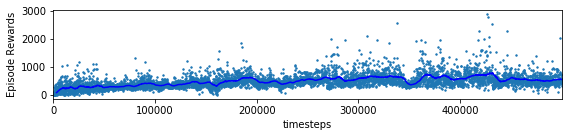

In [7]:
from stable_baselines import results_plotter
import matplotlib.pyplot as plt
plt.figure()
results_plotter.plot_results(["."], timesteps, results_plotter.X_TIMESTEPS, "")
plt.show()

In [8]:
obs = env.reset()
try:
    for _ in range(10000):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        env.render()
finally:
    env.close()

Creating window glfw
You can access the simulator by self.sim


ModuleNotFoundError: No module named 'ipdb'

In [9]:
# model.save('PP02_500000_timealivereward')